In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import pickle
import pathlib
import warnings
import scipy.signal as signal


In [10]:
behav_df = pd.read_csv('/home/qmoreau/Documents/Beta_bursts/Behavioral/behav_df_cleaned_new.csv')

# Load df_mask correctly, removing the extra index column
df_mask = pd.read_csv('/home/qmoreau/Documents/Beta_bursts/Behavioral/behav_df_mask.csv', index_col=0)

# Ensure we are using the correct boolean column
df_mask = df_mask.iloc[:, 0]  # Select the first column, which is boolean

# Apply the mask correctly
behav_df = behav_df[df_mask.values]


In [12]:
# Parameters for time windows
start_time = -1
end_time = 1.5
window_size = 0.2  # 200 ms
step_size = 0.1    # 100 ms

# Custom unpickler to handle PosixPath
class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == "pathlib" and name == "WindowPath":
            return pathlib.WindowsPath
        return super().find_class(module, name)

# Directory where files are stored
data_dir = '/home/qmoreau/Documents/Beta_bursts/Burst files/beta_output/'

# Get all pickle files
files = [file for file in os.listdir(data_dir) if file.endswith('.pickle')]

# Directory to save the outputs
output_dir = '/home/qmoreau/Documents/Beta_bursts/Beta_Power/'

# Loop through time windows
current_start = start_time
while current_start + window_size <= end_time:
    current_end = current_start + window_size

    # Initialize list to store results for this time window
    all_results = []

    # Process each file
    for file in files:
        # Extract subject and block from filename
        parts = file.split('-')
        subject = parts[0] + '-' + parts[1]  # e.g., "sub-101"
        block_str = parts[2]  # e.g., "002"
        block = int(block_str) - 2  # Calculate block value

        # Load the data using the custom unpickler
        file_path = os.path.join(data_dir, file)
        with open(file_path, 'rb') as f:
            data = CustomUnpickler(f).load()

        # Extract time array and identify the indices for the current time window
        time = pd.Series(data['time'], name='time')
        time_window_mask = (time >= current_start) & (time < current_end)
        time_window_indices = np.where(time_window_mask)[0]

        # Process trials and calculate average power
        num_trials = data['MLC21'].shape[0]  # Assuming all MLC channels have the same number of trials
        for trial in range(num_trials):
            # Calculate average across all electrodes for this trial
            avg_power = np.mean([
                data[key][trial, time_window_indices].mean()  # Average power for this trial and electrode
                for key in data.keys() if key.startswith('MLC')
            ])
            # Append results for this trial
            all_results.append({
                'subject': subject,
                'block': block,
                'trial': trial,  # Start trials at 0
                'beta_power': avg_power,
                'start_time': current_start,
                'end_time': current_end
            })

    # Convert results to a DataFrame
    final_df = pd.DataFrame(all_results)
    
    # Correct subject mappings if needed
    # final_df['subject'] = final_df['subject'].replace('sub-127', 'sub-133')
    # final_df['subject'] = final_df['subject'].replace('sub-134', 'sub-127')

    # Merge with behavioral data
    merged_df = pd.merge(final_df, behav_df, on=['subject', 'block', 'trial'], how='inner')

    # Save the DataFrame for this time window
    # Use string formatting for current_start and current_end
    start_str = f"{current_start:.3f}".rstrip('0').rstrip('.')
    end_str = f"{current_end:.3f}".rstrip('0').rstrip('.')

    # Handle the case where small negative values might display as '-0'
    if start_str == '-0':
        start_str = '0'
    if end_str == '-0':
        end_str = '0'

    # Save the DataFrame for this time window
    window_name = f"behav_df_power_window_{start_str}_{end_str}.csv"
    save_path = os.path.join(output_dir, window_name)
    merged_df.to_csv(save_path, index=False)
    
    

    # Confirmation message
    print(f"Merged DataFrame for window {current_start:.1f} to {current_end:.1f} saved to {save_path}")

    # Update to the next time window
    current_start += step_size
    
class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == "pathlib" and name == "WindowPath":
            return pathlib.WindowsPath
        return super().find_class(module, name)


# Get all pickle files
files = [file for file in os.listdir(data_dir) if file.endswith('.pickle')]

subject_ids = behav_df['subject'].unique()

filtered_subjects_data = []
trial_drop_summary = []
removed_trials_dict = {}  # Dictionary to store removed trials

for selected_subject in subject_ids:
    subject_files = [f for f in files if selected_subject in f]

    epochs_list = [CustomUnpickler(open(os.path.join(data_dir, f), "rb")).load() for f in subject_files]

    all_meg_data = {}
    for epochs in epochs_list:
        for sensor, data in epochs.items():
            all_meg_data.setdefault(sensor, []).append(data)

    time = epochs['time']
    for sensor in all_meg_data:
        valid_arrays = [arr for arr in all_meg_data[sensor] if isinstance(arr, np.ndarray) and arr.ndim == 2 and arr.shape[1] == 1501]
        all_meg_data[sensor] = np.concatenate(valid_arrays, axis=0) if valid_arrays else None

    all_meg_data = {ch: data for ch, data in all_meg_data.items() if data is not None}

    data_all_trials = np.stack(list(all_meg_data.values()))
    grand_avg_per_trial = np.mean(data_all_trials, axis=0)

    # Convert time series per trial into a single column
    meg_df = pd.DataFrame({
        'subject': selected_subject,
        'trial': np.arange(grand_avg_per_trial.shape[0]),
        'meg_signal': [arr for arr in grand_avg_per_trial]  # Store time series as arrays
    })

    # Get behavioral data for this subject
    behav_subject_data = behav_df[behav_df['subject'] == selected_subject].reset_index(drop=True)

    # Record the original trial count before filtering
    original_meg_trials = meg_df.shape[0]
    original_behav_trials = behav_subject_data.shape[0]

    # Identify common trials
    common_trials = set(meg_df['trial']).intersection(set(behav_subject_data.index))

    # Convert set to sorted list before indexing
    common_trials_sorted = sorted(list(common_trials))

    # Track removed trials due to no match
    no_match_removed_trials = list(set(behav_subject_data.index) - set(common_trials_sorted))

    # Filter both MEG and behavioral data to keep only common trials
    meg_df = meg_df[meg_df['trial'].isin(common_trials_sorted)].reset_index(drop=True)
    behav_subject_data = behav_subject_data.loc[common_trials_sorted].reset_index(drop=True)

    # Count the number of trials removed due to lack of common trials
    trials_dropped_no_match = (original_meg_trials + original_behav_trials) // 2 - meg_df.shape[0]

    # Ensure trial numbers match before merging
    if meg_df.shape[0] != behav_subject_data.shape[0]:
        print(f"Warning: Mismatch persists for {selected_subject} after filtering. MEG trials: {meg_df.shape[0]}, Behav trials: {behav_subject_data.shape[0]}")
        continue

    merged_df = pd.concat([behav_subject_data, meg_df.drop(columns=['subject'])], axis=1)

    # Compute mean and standard deviation across all trials for this subject
    all_meg_values = np.concatenate(merged_df['meg_signal'].values)  # Flatten all trials
    subject_mean = np.mean(all_meg_values)
    subject_std = np.std(all_meg_values)

    # Define a function to check if a trial exceeds 15 SD
    def is_outlier(trial_signal):
        return np.any(np.abs(trial_signal - subject_mean) > 10 * subject_std)

    # Count trials before outlier removal
    before_outlier_removal = merged_df.shape[0]

    # Track outlier removed trials
    outlier_removed_trials = merged_df[merged_df['meg_signal'].apply(is_outlier)].index.tolist()

    # Remove trials where any time point in the MEG signal exceeds 6SD
    merged_df = merged_df[~merged_df['meg_signal'].apply(is_outlier)].reset_index(drop=True)

    # Count the number of trials removed due to outliers
    trials_dropped_outliers = before_outlier_removal - merged_df.shape[0]

    print(f"Subject {selected_subject}: {trials_dropped_no_match} trials dropped due to no match, {trials_dropped_outliers} trials dropped due to outliers")

    # Store removed trials for this subject
    removed_trials_dict[selected_subject] = {
        'no_match_removed_trials': no_match_removed_trials,
        'outlier_removed_trials': outlier_removed_trials
    }

    filtered_subjects_data.append(merged_df)

# Concatenate all subjects' filtered data into a single DataFrame
final_df = pd.concat(filtered_subjects_data, ignore_index=True)

# Optional: Print out removed trials
for subject, removed_info in removed_trials_dict.items():
    print(f"\nSubject {subject}:")
    print("Trials removed due to no match:", removed_info['no_match_removed_trials'])
    print("Trials removed due to outliers:", removed_info['outlier_removed_trials'])



Merged DataFrame for window -1.0 to -0.8 saved to /home/qmoreau/Documents/Beta_bursts/Beta_Power/behav_df_power_window_-1_-0.8.csv
Merged DataFrame for window -0.9 to -0.7 saved to /home/qmoreau/Documents/Beta_bursts/Beta_Power/behav_df_power_window_-0.9_-0.7.csv
Merged DataFrame for window -0.8 to -0.6 saved to /home/qmoreau/Documents/Beta_bursts/Beta_Power/behav_df_power_window_-0.8_-0.6.csv
Merged DataFrame for window -0.7 to -0.5 saved to /home/qmoreau/Documents/Beta_bursts/Beta_Power/behav_df_power_window_-0.7_-0.5.csv
Merged DataFrame for window -0.6 to -0.4 saved to /home/qmoreau/Documents/Beta_bursts/Beta_Power/behav_df_power_window_-0.6_-0.4.csv
Merged DataFrame for window -0.5 to -0.3 saved to /home/qmoreau/Documents/Beta_bursts/Beta_Power/behav_df_power_window_-0.5_-0.3.csv
Merged DataFrame for window -0.4 to -0.2 saved to /home/qmoreau/Documents/Beta_bursts/Beta_Power/behav_df_power_window_-0.4_-0.2.csv
Merged DataFrame for window -0.3 to -0.1 saved to /home/qmoreau/Documen

In [13]:
from scipy.stats import sem  # Standard Error of the Mean

# Define baseline period and plotting window
baseline_mask = (time >= -0.75) & (time <= -0.5)
plot_mask = (time >= -0.75) & (time <= 1)

# Separate groups
explicit_df = final_df[final_df['group'] == 'Explicit']
implicit_df = final_df[final_df['group'] == 'Implicit']

subject_explicit = explicit_df['subject'].unique()
subject_implicit = implicit_df['subject'].unique()

# Compute subject-level averages with baseline correction
explicit_subject_data = {}
implicit_subject_data = {}

for subject in subject_explicit:
    subj_data = explicit_df[explicit_df['subject'] == subject]
    if not subj_data.empty:
        subject_meg = np.stack(subj_data['meg_signal'].values)
        subject_avg = subject_meg.mean(axis=0)
        baseline_value = np.mean(subject_avg[baseline_mask])
        subject_corrected = 100 * (subject_avg - baseline_value) / abs(baseline_value) if baseline_value != 0 else subject_avg
        explicit_subject_data[subject] = subject_corrected

for subject in subject_implicit:
    subj_data = implicit_df[implicit_df['subject'] == subject]
    if not subj_data.empty:
        subject_meg = np.stack(subj_data['meg_signal'].values)
        subject_avg = subject_meg.mean(axis=0)
        baseline_value = np.mean(subject_avg[baseline_mask])
        subject_corrected = 100 * (subject_avg - baseline_value) / abs(baseline_value) if baseline_value != 0 else subject_avg
        implicit_subject_data[subject] = subject_corrected

# Convert subject data to numpy arrays
explicit_array = np.stack(list(explicit_subject_data.values()))
implicit_array = np.stack(list(implicit_subject_data.values()))

# Compute mean and SEM
explicit_subject_avg = explicit_array.mean(axis=0)
implicit_subject_avg = implicit_array.mean(axis=0)
combined_avg = np.mean([explicit_subject_avg, implicit_subject_avg], axis=0)

explicit_sem = sem(explicit_array, axis=0)  # SEM across subjects
implicit_sem = sem(implicit_array, axis=0)
combined_sem = np.sqrt((explicit_sem**2 + implicit_sem**2) / 2)  # Approximate combined SEM

# Apply plot mask
time_plot = time[plot_mask]
explicit_plot = explicit_subject_avg[plot_mask]
implicit_plot = implicit_subject_avg[plot_mask]
combined_plot = combined_avg[plot_mask]

explicit_sem_plot = explicit_sem[plot_mask]
implicit_sem_plot = implicit_sem[plot_mask]
combined_sem_plot = combined_sem[plot_mask]

In [14]:
# Define color palettes
colors0 = sns.color_palette("magma", n_colors=6)
colors1 = sns.color_palette("mako_r", n_colors=10)
pastel = sns.color_palette("Pastel1", n_colors=6)
adapt1 = sns.color_palette("Set1", n_colors=9)
adapt2 = sns.color_palette("Accent", n_colors=8)
colors4 = sns.color_palette("magma_r", n_colors=4)
colors5 = sns.color_palette("mako_r", n_colors=4)

colors2 = [pastel[0], pastel[3], adapt2[5]]
colors3 = [pastel[1], pastel[2], colors5[2]]
colorbl = [adapt1[4], colors1[2]]  # Blue-Red scheme for Explicit vs. Implicit

In [21]:

import pandas as pd
import pathlib
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests

class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == "pathlib" and name == "WindowPath":
            return pathlib.WindowsPath
        return super().find_class(module, name)

def format_window(value):
    formatted = f"{value:.3f}".rstrip('0').rstrip('.')
    return formatted if formatted != "-0" else "0"

data_dir = '/home/qmoreau/Documents/Beta_bursts/Burst files/beta_output'
base_path = '/home/qmoreau/Documents/Beta_bursts/Beta_Power'
output_dir = '/home/qmoreau/Documents/Beta_bursts/Beta_Power/Beta_Power_Filtered'
os.makedirs(output_dir, exist_ok=True)

files = [file for file in os.listdir(data_dir) if file.endswith('.pickle')]
subject_ids = set()
for file in files:
    parts = file.split('-')
    if len(parts) >= 2:
        subject_ids.add(parts[0] + '-' + parts[1])

outlier_dict = {}

for selected_subject in subject_ids:
    subject_files = [f for f in files if selected_subject in f]
    if not subject_files:
        continue
    
    epochs_list = []
    for f in subject_files:
        try:
            with open(os.path.join(data_dir, f), "rb") as file:
                epochs_list.append(CustomUnpickler(file).load())
        except Exception:
            continue
    
    if not epochs_list:
        continue
    
    all_meg_data = {}
    for epochs in epochs_list:
        for sensor, data in epochs.items():
            if sensor != 'time':
                all_meg_data.setdefault(sensor, []).append(data)
    
    valid_meg_data = {}
    for sensor in all_meg_data:
        valid_arrays = [arr for arr in all_meg_data[sensor] 
                         if isinstance(arr, np.ndarray) and arr.ndim == 2 and arr.shape[1] == 1501]
        if valid_arrays:
            valid_meg_data[sensor] = np.concatenate(valid_arrays, axis=0)
    
    if not valid_meg_data:
        continue
    
    data_all_trials = np.stack(list(valid_meg_data.values()))
    grand_avg_per_trial = np.mean(data_all_trials, axis=0)
    
    meg_df = pd.DataFrame({
        'subject': selected_subject,
        'trial': np.arange(grand_avg_per_trial.shape[0]),
        'meg_signal': [arr for arr in grand_avg_per_trial]
    })
    
    all_meg_values = np.concatenate(meg_df['meg_signal'].values)
    subject_mean = np.mean(all_meg_values)
    subject_std = np.std(all_meg_values)
    
    outlier_mask = meg_df['meg_signal'].apply(
        lambda x: np.any(np.abs(x - subject_mean) > 10 * subject_std)
    )
    outlier_trials = meg_df.loc[outlier_mask, 'trial'].tolist()
    outlier_dict[selected_subject] = outlier_trials

start, end, step = -1, 1, 0.1
window_start = np.around(np.arange(start, end + step, step), 1).tolist()
window_end = np.around(np.arange(start + 0.2, end + 0.2 + step, step), 1).tolist()

for w_start, w_end in zip(window_start, window_end):
    window_str = f"behav_df_power_window_{format_window(w_start)}_{format_window(w_end)}.csv"
    file_path = os.path.join(base_path, window_str)
    
    if not os.path.exists(file_path):
        continue
    
    data = pd.read_csv(file_path)
    data = data[(data['block'] > 0) & (data['block'] < 7)].dropna(
        subset=["reach_vis_abs_err", "beta_power", "group", "subject"]
    )
    
    data['group'] = pd.Categorical(data['group'], categories=['Explicit', 'Implicit'])
    data['subject'] = data['subject'].astype('str')
    
    filtered_data = []
    for subject in data['subject'].unique():
        subject_data = data[data['subject'] == subject]
        subject_outliers = outlier_dict.get(subject, [])
        if subject_outliers:
            subject_data = subject_data[~subject_data['trial'].isin(subject_outliers)]
        filtered_data.append(subject_data)
    
    if filtered_data:
        filtered_df = pd.concat(filtered_data, ignore_index=True)
    else:
        filtered_df = pd.DataFrame()
    
    output_path = os.path.join(output_dir, f"filtered_{window_str}")
    filtered_df.to_csv(output_path, index=False)

results_overall = []
results_explicit = []
results_implicit = []
significant_interactions = []

for w_start, w_end in zip(window_start, window_end):
    window_str = f"filtered_behav_df_power_window_{format_window(w_start)}_{format_window(w_end)}.csv"
    file_path = os.path.join(output_dir, window_str)
    
    if not os.path.exists(file_path):
        continue
    
    window_mid = round(w_start + 0.5 * (w_end - w_start), 2)
    data = pd.read_csv(file_path)
    
    if data.empty:
        continue
    
    data['group'] = pd.Categorical(data['group'], categories=['Explicit', 'Implicit'])
    data['subject'] = data['subject'].astype('category')
    data['log_rt'] = np.log10(data['reach_rt'])
    
    try:
        model_main_only = mixedlm(
            "reach_vis_abs_err ~ beta_power + group", 
            data, 
            groups=data['subject'], 
            re_formula="1"
        )
        model_main_only_fit = model_main_only.fit()
        
        results_overall.append({
            'window': window_mid,
            'Estimate': model_main_only_fit.params['beta_power'],
            'SE': model_main_only_fit.bse['beta_power'],
            'p_value': model_main_only_fit.pvalues['beta_power']
        })
    except Exception:
        pass
    
    try:
        model_interaction = mixedlm(
            "reach_vis_abs_err ~ beta_power * group", 
            data, 
            groups=data['subject'], 
            re_formula="1"
        )
        model_interaction_fit = model_interaction.fit()
        
        interaction_p_value = model_interaction_fit.pvalues.get("beta_power:group[T.Implicit]", np.nan)
        
        if interaction_p_value < 0.05:
            significant_interactions.append({
                "window": window_mid,
                "p_value": interaction_p_value
            })
            
    except Exception:
        pass
    
    explicit_data = data[data['group'] == 'Explicit']
    if not explicit_data.empty:
        try:
            model = mixedlm(
                "reach_vis_abs_err ~ beta_power", 
                explicit_data, 
                groups=explicit_data['subject'], 
                re_formula="1"
            ).fit()
            results_explicit.append({
                'window': window_mid,
                'Estimate': model.params['beta_power'],
                'SE': model.bse['beta_power'],
                'p_value': model.pvalues['beta_power']
            })
        except Exception:
            pass

    implicit_data = data[data['group'] == 'Implicit']
    if not implicit_data.empty:
        try:
            model = mixedlm(
                "reach_vis_abs_err ~ beta_power", 
                implicit_data, 
                groups=implicit_data['subject'], 
                re_formula="1"
            ).fit()
            results_implicit.append({
                'window': window_mid,
                'Estimate': model.params['beta_power'],
                'SE': model.bse['beta_power'],
                'p_value': model.pvalues['beta_power']
            })
        except Exception:
            pass

results_overall_df = pd.DataFrame(results_overall)
results_explicit_df = pd.DataFrame(results_explicit)
results_implicit_df = pd.DataFrame(results_implicit)

for df in [results_overall_df, results_explicit_df, results_implicit_df]:
    if not df.empty:
        p_values = df['p_value'].dropna()
        if len(p_values) > 0:
            df['p_value_fdr'] = multipletests(p_values, method='fdr_bh')[1]

for df in [results_overall_df, results_explicit_df, results_implicit_df]:
    if 'p_value_fdr' in df.columns:
        df["annotate"] = df["p_value_fdr"].apply(lambda p: "*" if p < 0.05 else "")

results_overall_df.to_csv(os.path.join(output_dir, "results_overall_filtered.csv"), index=False)
results_explicit_df.to_csv(os.path.join(output_dir, "results_explicit_filtered.csv"), index=False)
results_implicit_df.to_csv(os.path.join(output_dir, "results_implicit_filtered.csv"), index=False)

if significant_interactions:
    pd.DataFrame(significant_interactions).to_csv(
        os.path.join(output_dir, "significant_interactions_filtered.csv"), 
        index=False
    )

/home/qmoreau/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/qmoreau/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [22]:
results_overall_df

,window,Estimate,SE,p_value,p_value_fdr,annotate
0,-0.9,7.867574e+11,8.305188e+11,0.343482,0.932408,
1,-0.8,2.961283e+12,3.145221e+12,0.346439,0.932408,
2,-0.7,-3.528457e+11,1.672282e+12,0.832890,0.932408,
3,-0.6,-2.618056e+11,7.100760e+11,0.712351,0.932408,
4,-0.5,-3.231627e+11,8.625894e+11,0.707926,0.932408,
5,-0.4,-5.820033e+10,5.693917e+11,0.918586,0.932408,
6,-0.3,-1.024406e+10,1.207813e+11,0.932408,0.932408,
7,-0.2,-8.161699e+09,8.766402e+10,0.925823,0.932408,
8,-0.1,-2.034130e+10,1.817603e+11,0.910893,0.932408,
9,0.0,-3.494041e+11,1.051127e+12,0.739580,0.932408,


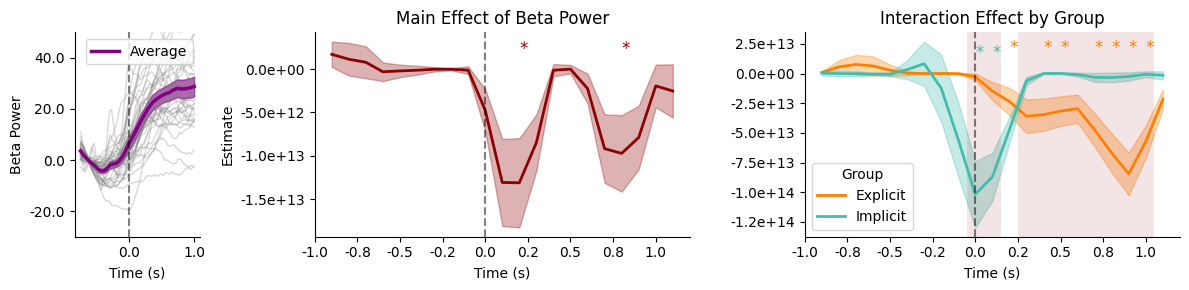

In [23]:
# import ticker
import matplotlib.ticker as ticker

adapt1 = sns.color_palette("Set1", n_colors=9)
colors1 = sns.color_palette("mako_r", n_colors=10)
colorbl = [adapt1[4], colors1[2]]  

# Define figure with adjusted layout
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), gridspec_kw={'width_ratios': [1, 3, 3]})
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Define baseline period and plotting window
baseline_mask = (time >= -0.75) & (time <= -0.5)
plot_mask = (time >= -0.75) & (time <= 1)

ax_left = axes[0]

# Plot individual subject traces with alpha=0.1
for subject_data in explicit_array:
    ax_left.plot(time_plot, subject_data[plot_mask], color="grey", alpha=0.3, linewidth=1)

for subject_data in implicit_array:
    ax_left.plot(time_plot, subject_data[plot_mask], color="grey", alpha=0.3, linewidth=1)

# Plot combined average
ax_left.plot(time_plot, combined_plot, label="Average", color='purple', alpha=1, linewidth=2.5)
ax_left.fill_between(time_plot, combined_plot - combined_sem_plot, combined_plot + combined_sem_plot, color='purple', alpha=0.6)

# Aesthetic adjustments
ax_left.axvline(x=0, linestyle='dashed', color='black', alpha=0.5)  # Event onset
ax_left.set_ylim(-30, 50)
ax_left.set_xlabel("Time (s)")
ax_left.set_ylabel("Beta Power")
ax_left.legend(loc='upper right')
ax_left.spines['right'].set_visible(False)
ax_left.spines['top'].set_visible(False)

# Axes for results
ax_main_effect = axes[1]
ax_interaction = axes[2]

smoothed_data = {}
smooth_window = 3

# Create dictionary to match datasets with plot names
group_data_map = {
    "Overall": results_overall_df,
    "Explicit": results_explicit_df,
    "Implicit": results_implicit_df
}

# Apply smoothing and store results
for group, df in group_data_map.items():
    df = df.sort_values("window")
    
    if len(df) > smooth_window:
        smoothed_estimates = signal.savgol_filter(df["Estimate"].values, smooth_window, 1)
        smoothed_se = signal.savgol_filter(df["SE"].values, smooth_window, 1)
        
        df["Smoothed_Estimate"] = smoothed_estimates
        df["Smoothed_SE"] = smoothed_se
    else:
        df["Smoothed_Estimate"] = df["Estimate"]
        df["Smoothed_SE"] = df["SE"]

    smoothed_data[group] = df

# Main Effect Plot (Overall Model)
main_effect_df = smoothed_data["Overall"]
ax_main_effect.plot(main_effect_df["window"], main_effect_df["Smoothed_Estimate"], 
            color="darkred", label="Main Effect", linewidth=2)
ax_main_effect.fill_between(main_effect_df["window"],
                    main_effect_df["Smoothed_Estimate"] - main_effect_df["Smoothed_SE"],
                    main_effect_df["Smoothed_Estimate"] + main_effect_df["Smoothed_SE"],
                    alpha=0.3, color="darkred")

# Add red stars for significant main effects
for _, row in main_effect_df.iterrows():
    if row["p_value_fdr"] < 0.05:
        star_y_pos = np.max(main_effect_df["Smoothed_Estimate"]) + 1  # Position the star above the plot
        ax_main_effect.text(row["window"], star_y_pos, '*', color='darkred', fontsize=12)

ax_main_effect.set_title("Main Effect of Beta Power")
ax_main_effect.set_xlabel("Time (s)")
ax_main_effect.set_ylabel("Estimate")
ax_main_effect.axvline(x=0, linestyle='dashed', color='black', alpha=0.5)
ax_main_effect.spines['right'].set_visible(False)
ax_main_effect.spines['top'].set_visible(False)

# Interaction Plot (Explicit vs. Implicit)
for group, color, star_color, shift in zip(
    ["Explicit", "Implicit"], 
    colorbl, 
    colorbl,
    [1e13, 0.5e13]):
    group_df = smoothed_data[group]
    ax_interaction.plot(group_df["window"], group_df["Smoothed_Estimate"], 
                label=group, color=color, linewidth=2)
    ax_interaction.fill_between(group_df["window"],
                        group_df["Smoothed_Estimate"] - group_df["Smoothed_SE"],
                        group_df["Smoothed_Estimate"] + group_df["Smoothed_SE"],
                        alpha=0.3, color=color)
    
    # Add stars for significant effects with specific colors
    for _, row in group_df.iterrows():
        if row["p_value_fdr"] < 0.05:
            star_y_pos = np.max(group_df["Smoothed_Estimate"]) + 1
            ax_interaction.text(row["window"], star_y_pos + shift, '*', color=star_color, fontsize=12)

ax_interaction.set_title("Interaction Effect by Group")
ax_interaction.set_xlabel("Time (s)")
ax_interaction.legend(title="Group", loc='lower left')
ax_interaction.spines['right'].set_visible(False)
ax_interaction.axvline(x=0, linestyle='dashed', color='black', alpha=0.5)
ax_interaction.spines['top'].set_visible(False)

# Set tick format to display 1 decimal place
formatter = ticker.FormatStrFormatter('%.1f')

ax_left.xaxis.set_major_formatter(formatter)
ax_left.yaxis.set_major_formatter(formatter)

ax_main_effect.xaxis.set_major_formatter(formatter)
ax_main_effect.yaxis.set_major_formatter(formatter)

ax_interaction.xaxis.set_major_formatter(formatter)
ax_interaction.yaxis.set_major_formatter(formatter)

# For large values (e13), use scientific notation with one decimal
scientific_formatter = ticker.FuncFormatter(lambda x, _: f'{x:.1e}')

ax_main_effect.yaxis.set_major_formatter(scientific_formatter)
ax_interaction.yaxis.set_major_formatter(scientific_formatter)

significant_interactions_df = pd.DataFrame(significant_interactions)

# Group consecutive windows with significant interactions
if not significant_interactions_df.empty:
    # Sort windows
    significant_windows = sorted(significant_interactions_df['window'].tolist())
    
    # Group consecutive windows
    groups = []
    current_group = [significant_windows[0]] if significant_windows else []
    
    for i in range(1, len(significant_windows)):
        if abs(significant_windows[i] - significant_windows[i-1] - step) < 0.001:
            current_group.append(significant_windows[i])
        else:
            groups.append(current_group)
            current_group = [significant_windows[i]]
    
    if current_group:  # Add the last group if not empty
        groups.append(current_group)
    
    # Add shaded areas only for groups with at least two consecutive significant windows
    for group in groups:
        if len(group) >= 2:  # Only shade if there are at least 2 consecutive windows
            # Calculate the width of a single window
            half_width = step / 2
            
            # Shade from the start of the first window to the end of the last window
            start_x = group[0] - half_width
            end_x = group[-1] + half_width
            
            # Add shaded area to interaction plot
            ax_interaction.axvspan(start_x, end_x, alpha=0.1, color='darkred', linewidth=0)

plt.tight_layout()
plt.show()